# Timing of the pathways of WSBW and Prydz Bay bottom water

This notebook computes how long it takes for the tracer of a water mass to reach a certain threshold at each grid point (in the bottom 500 m). Thresholds are 10%, 15%, 30%... of the mean of the tracer concentration at each grid point.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import datetime
import xgcm
import cmcrameri


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
save_dir = '/g/data/x77/ps7863/data/AABW_variability'



In [3]:
climtas.nci.GadiClient()

<Client: 'tcp://127.0.0.1:37033' processes=48 threads=48, memory=190.00 GiB>

In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'
figdir = '/g/data/x77/ps7863/figures/AABW_variability/'

In [5]:
first_year = '1958'
last_year = '2018'
start_time=first_year+'-01-01'
end_time=last_year+'-12-31'
time_slice = slice(start_time, end_time)

lon_slice = slice(-70, 80)
lat_slice = slice(-82, -55)

In [6]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [7]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)

Load monthly tracer concentration data

In [8]:
wsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/WSBW_tracer_bottom_500_1958-2018.nc')
pbbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/PBBW_tracer_bottom_500_1958-2018.nc')
wsbw = wsbw['WSBW tracer']
pbbw = pbbw['PBBW tracer']

In [9]:
where_nan = np.isnan(wsbw.isel(time=1))
wsbw = wsbw.where(~where_nan,0)
where_nan = np.isnan(pbbw.isel(time=1))
pbbw = pbbw.where(~where_nan,0)

In [14]:
wsbw_mean = helper.annual_mean_from_monthly(wsbw)
condition = wsbw >= (wsbw_mean * 0.15)
wsbw_threshold_15 = wsbw.where(condition) 


pbbw_mean = helper.annual_mean_from_monthly(pbbw)
condition = pbbw >= (pbbw_mean * 0.15)
pbbw_threshold_15 = pbbw.where(condition) 

In [17]:
wsbw_time_indices_15 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    wsbw_threshold_15,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
wsbw_timing_15 = wsbw.isel(time=wsbw_time_indices_15).time.dt.date



pbbw_time_indices_15 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    pbbw_threshold_15,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
pbbw_timing_15 = pbbw.isel(time=pbbw_time_indices_15).time.dt.date


In [32]:
start_time = datetime.date(1958, 1, 16)
wsbw_timedelta = ((wsbw_timing_15 - start_time).dt.days / 365) # in years
pbbw_timedelta = ((pbbw_timing_15 - start_time).dt.days / 365) # in years

wsbw_timedelta_mon = ((wsbw_timing_15 - start_time).dt.days/30) # in months
pbbw_timedelta_mon = ((pbbw_timing_15 - start_time).dt.days/30) # in months

## Spherical maps

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [20]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [21]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [22]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [23]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [24]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

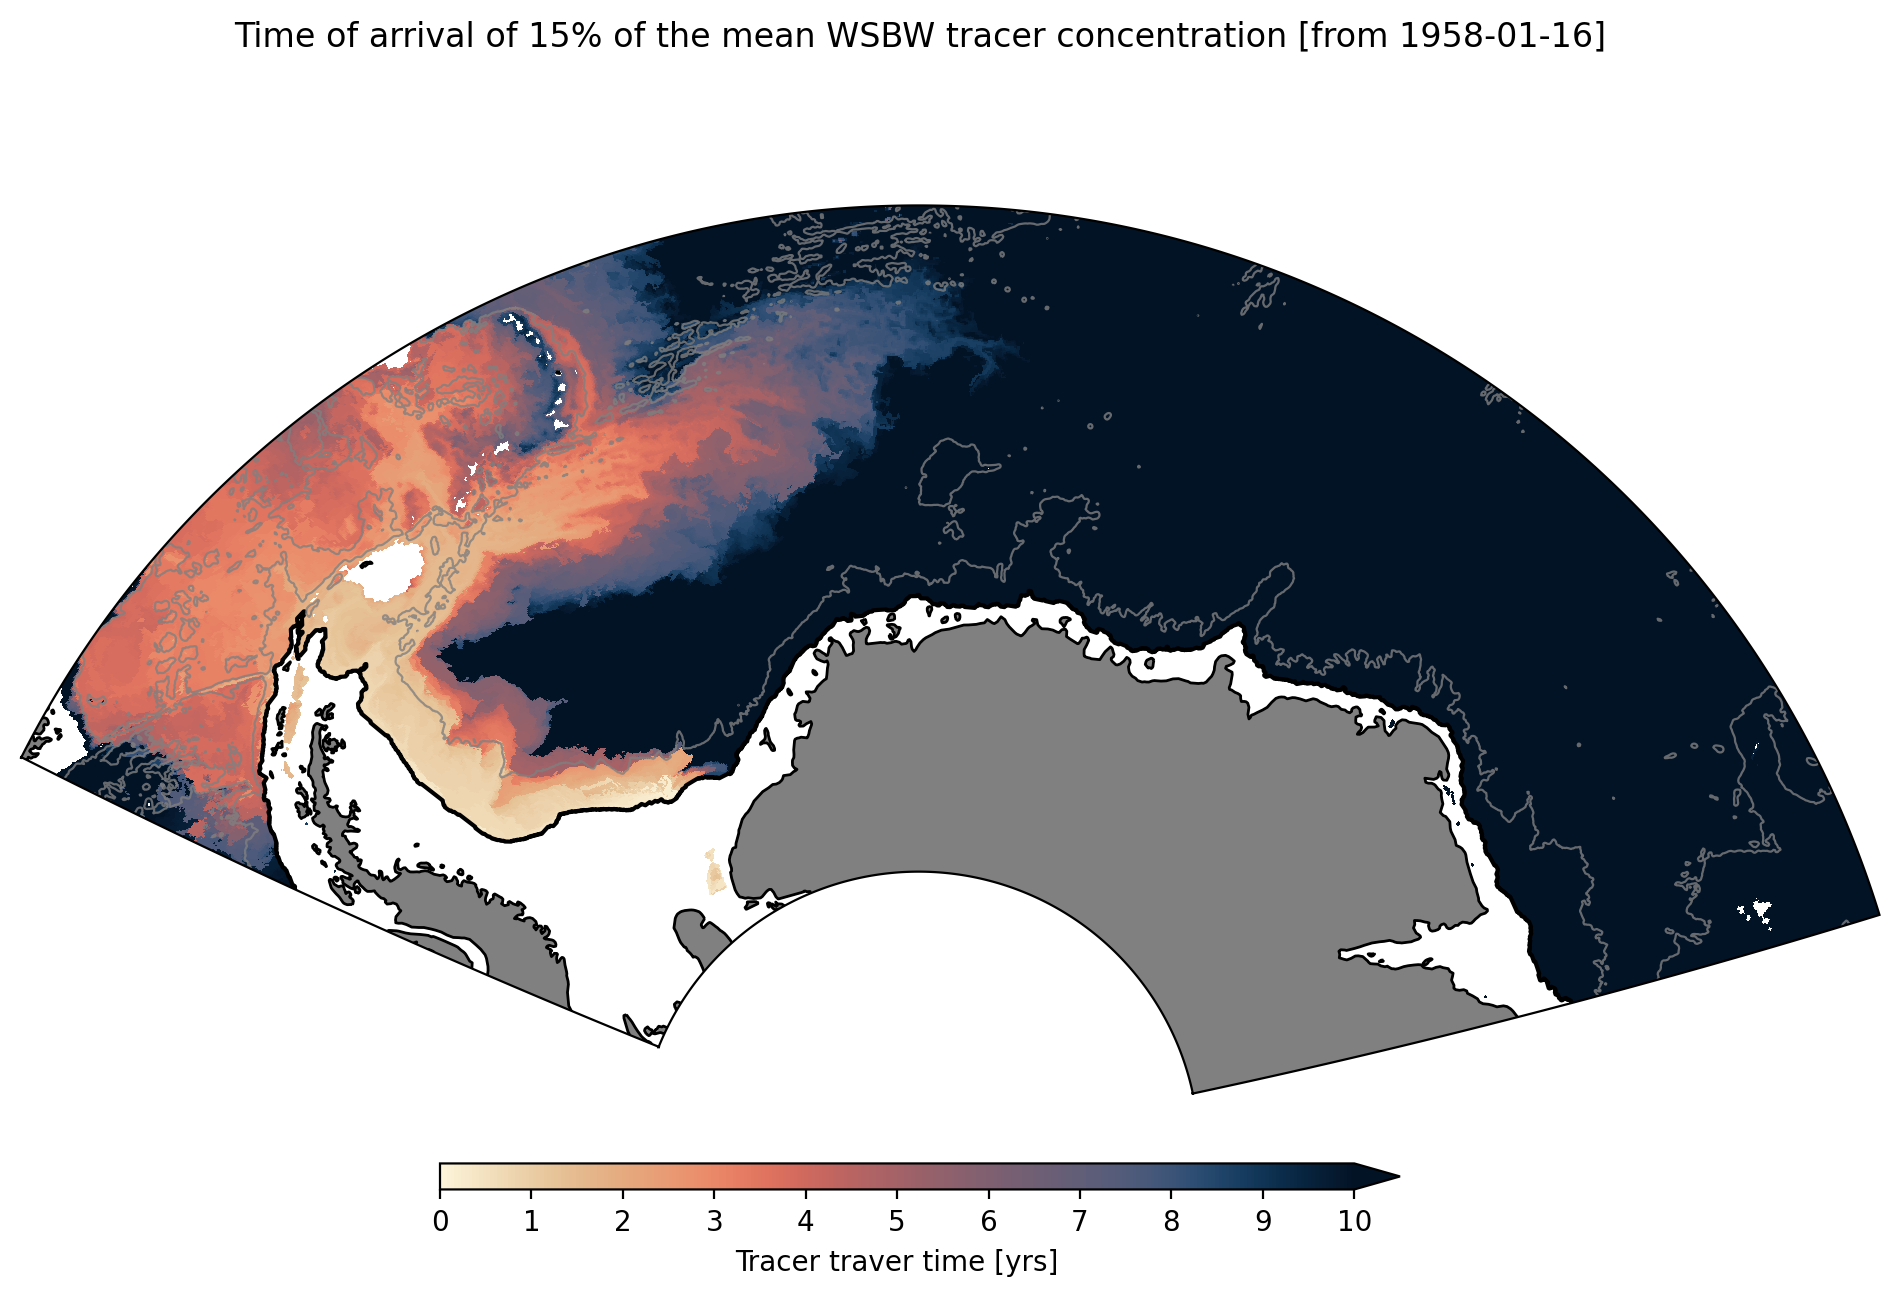

In [33]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer traver time [yrs]')

plt.suptitle('Time of arrival of 15% of the mean WSBW tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/wsbw_timing_map_15%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


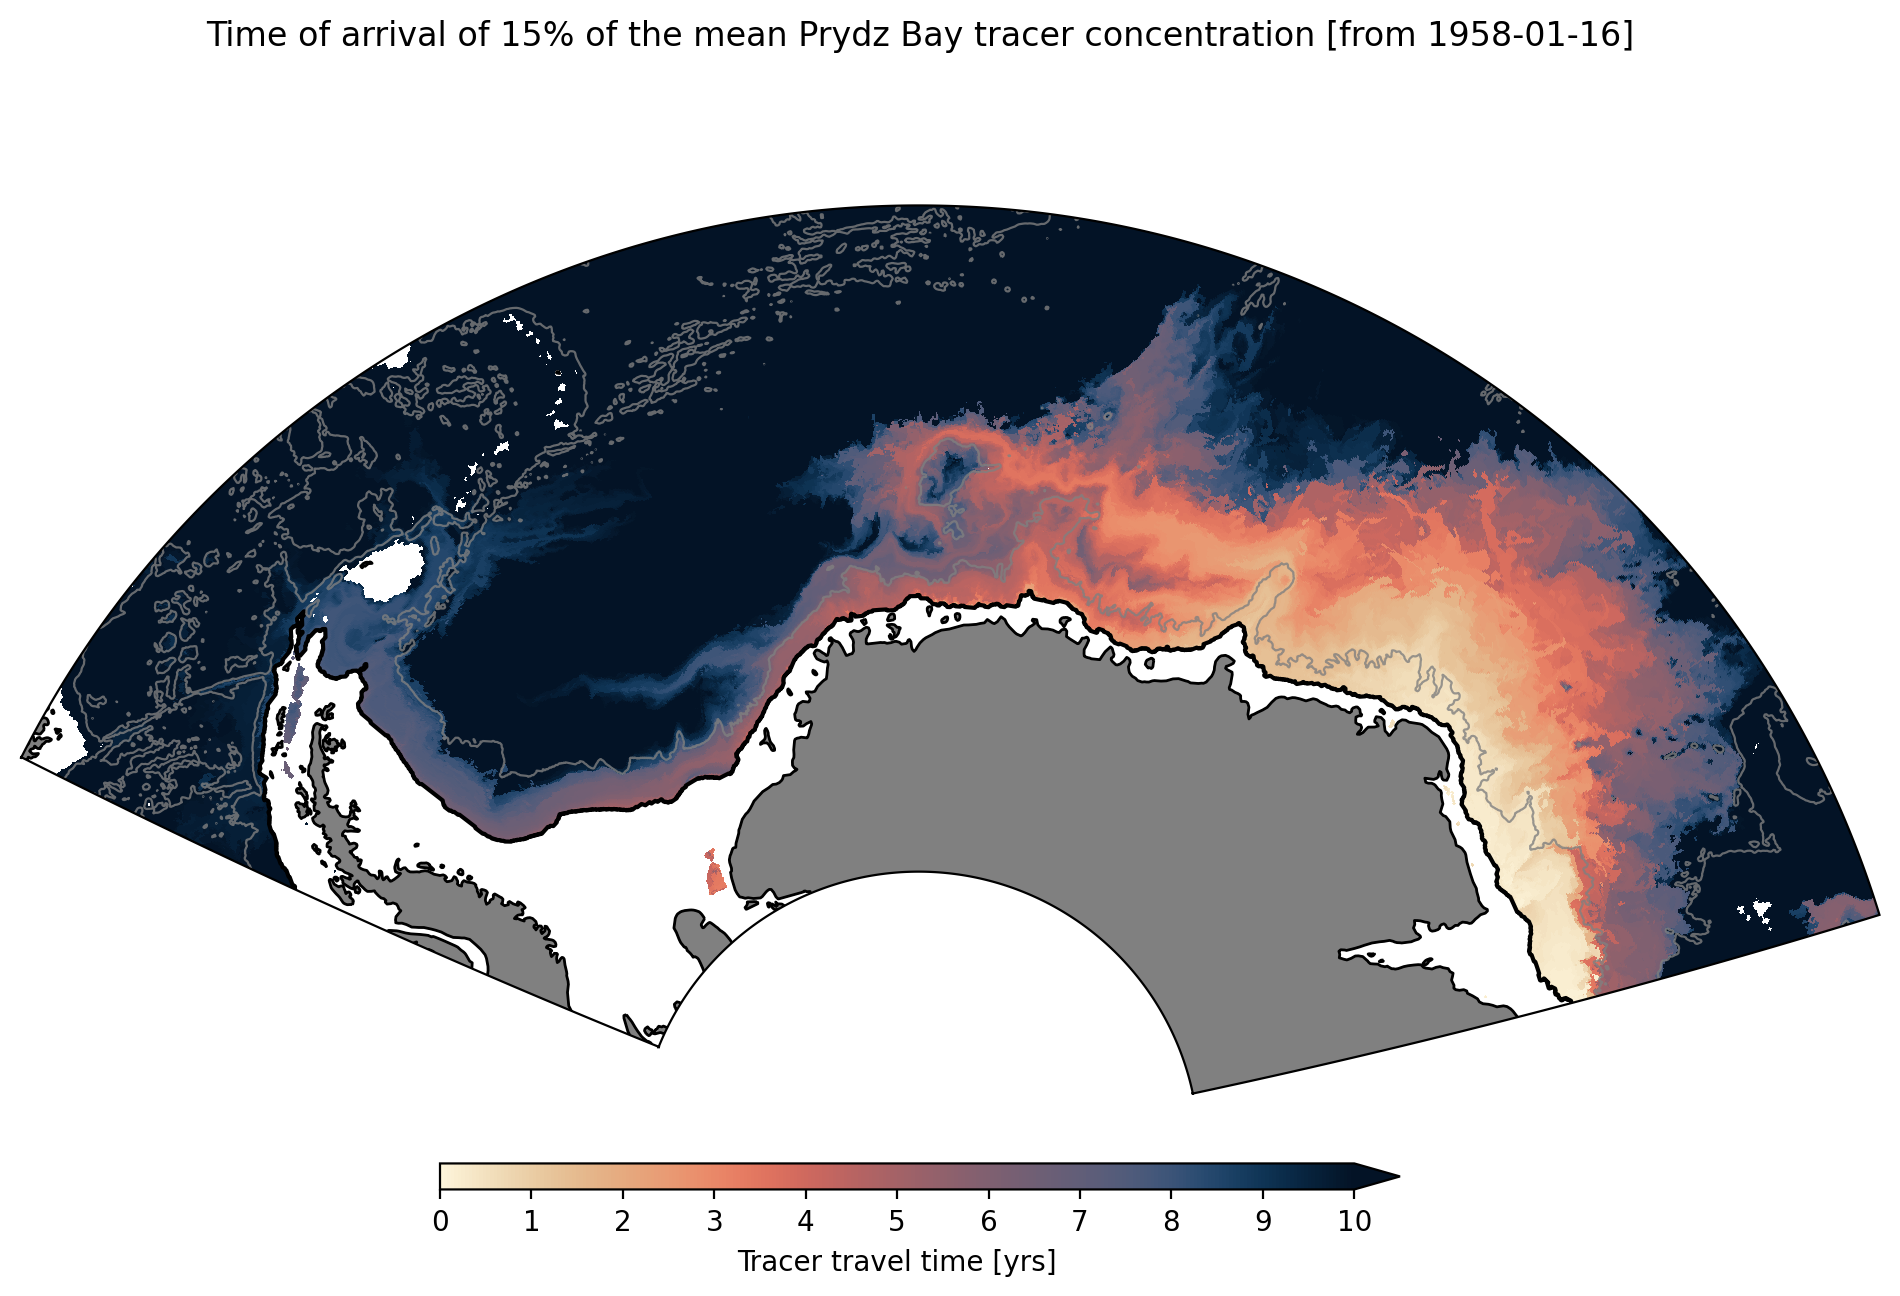

In [34]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, pbbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 15% of the mean Prydz Bay tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/pbbw_timing_map_15%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


## Threshold: 10% of the mean

In [27]:
condition = wsbw >= (wsbw_mean * 0.10)
wsbw_threshold_10 = wsbw.where(condition) 

condition = pbbw >= (pbbw_mean * 0.10)
pbbw_threshold_10 = pbbw.where(condition) 

In [35]:
wsbw_time_indices_10 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    wsbw_threshold_10,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
wsbw_timing_10 = wsbw.isel(time=wsbw_time_indices_10).time.dt.date



pbbw_time_indices_10 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    pbbw_threshold_10,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
pbbw_timing_10 = pbbw.isel(time=pbbw_time_indices_10).time.dt.date


In [36]:
start_time = datetime.date(1958, 1, 16)
wsbw_timedelta = ((wsbw_timing_10 - start_time).dt.days / 365) # in years
pbbw_timedelta = ((pbbw_timing_10 - start_time).dt.days / 365) # in years

wsbw_timedelta_mon = ((wsbw_timing_10 - start_time).dt.days/30) # in months
pbbw_timedelta_mon = ((pbbw_timing_10 - start_time).dt.days/30) # in months

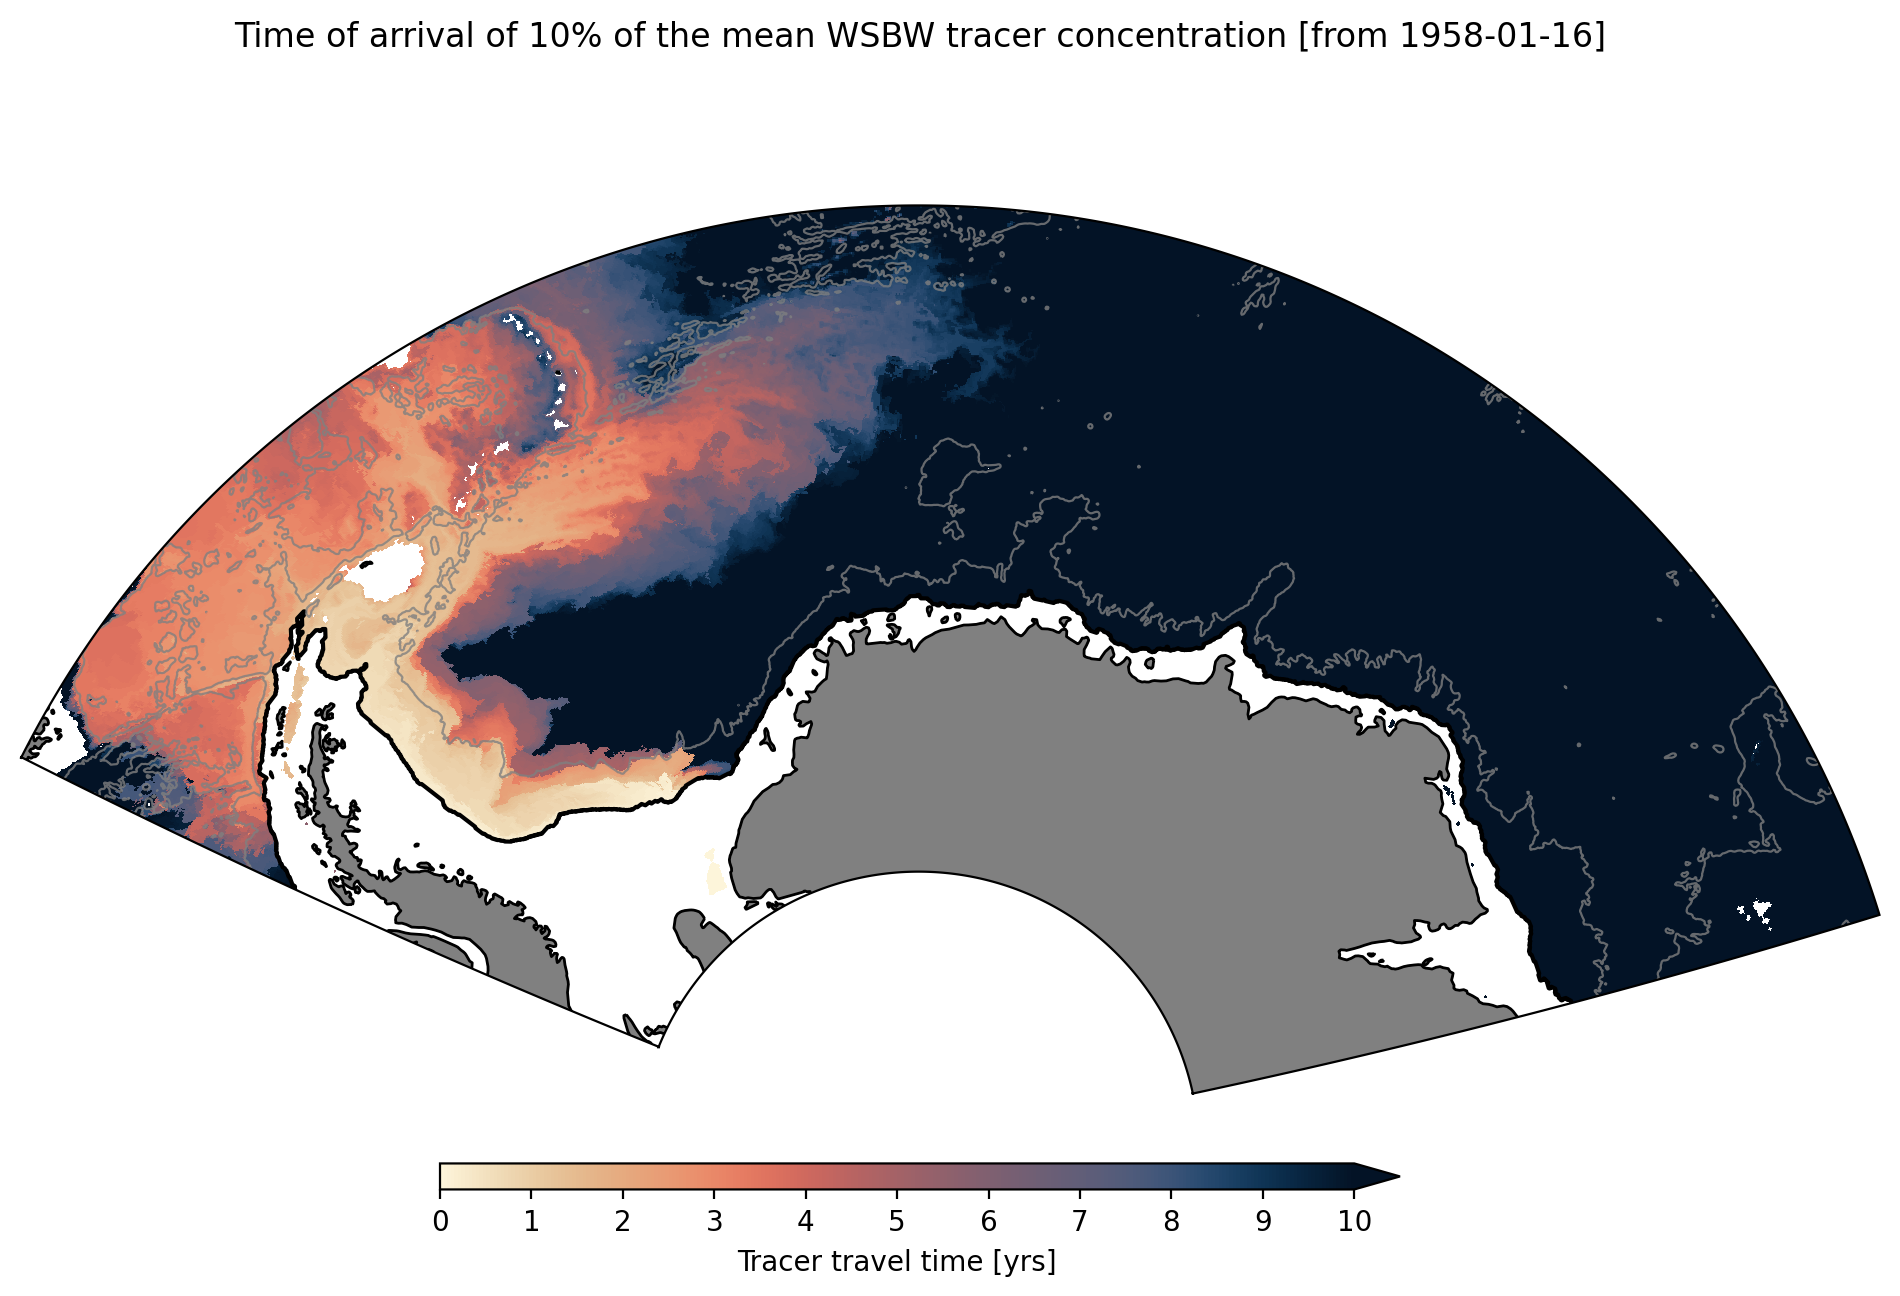

In [37]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 10% of the mean WSBW tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/wsbw_timing_map_10%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


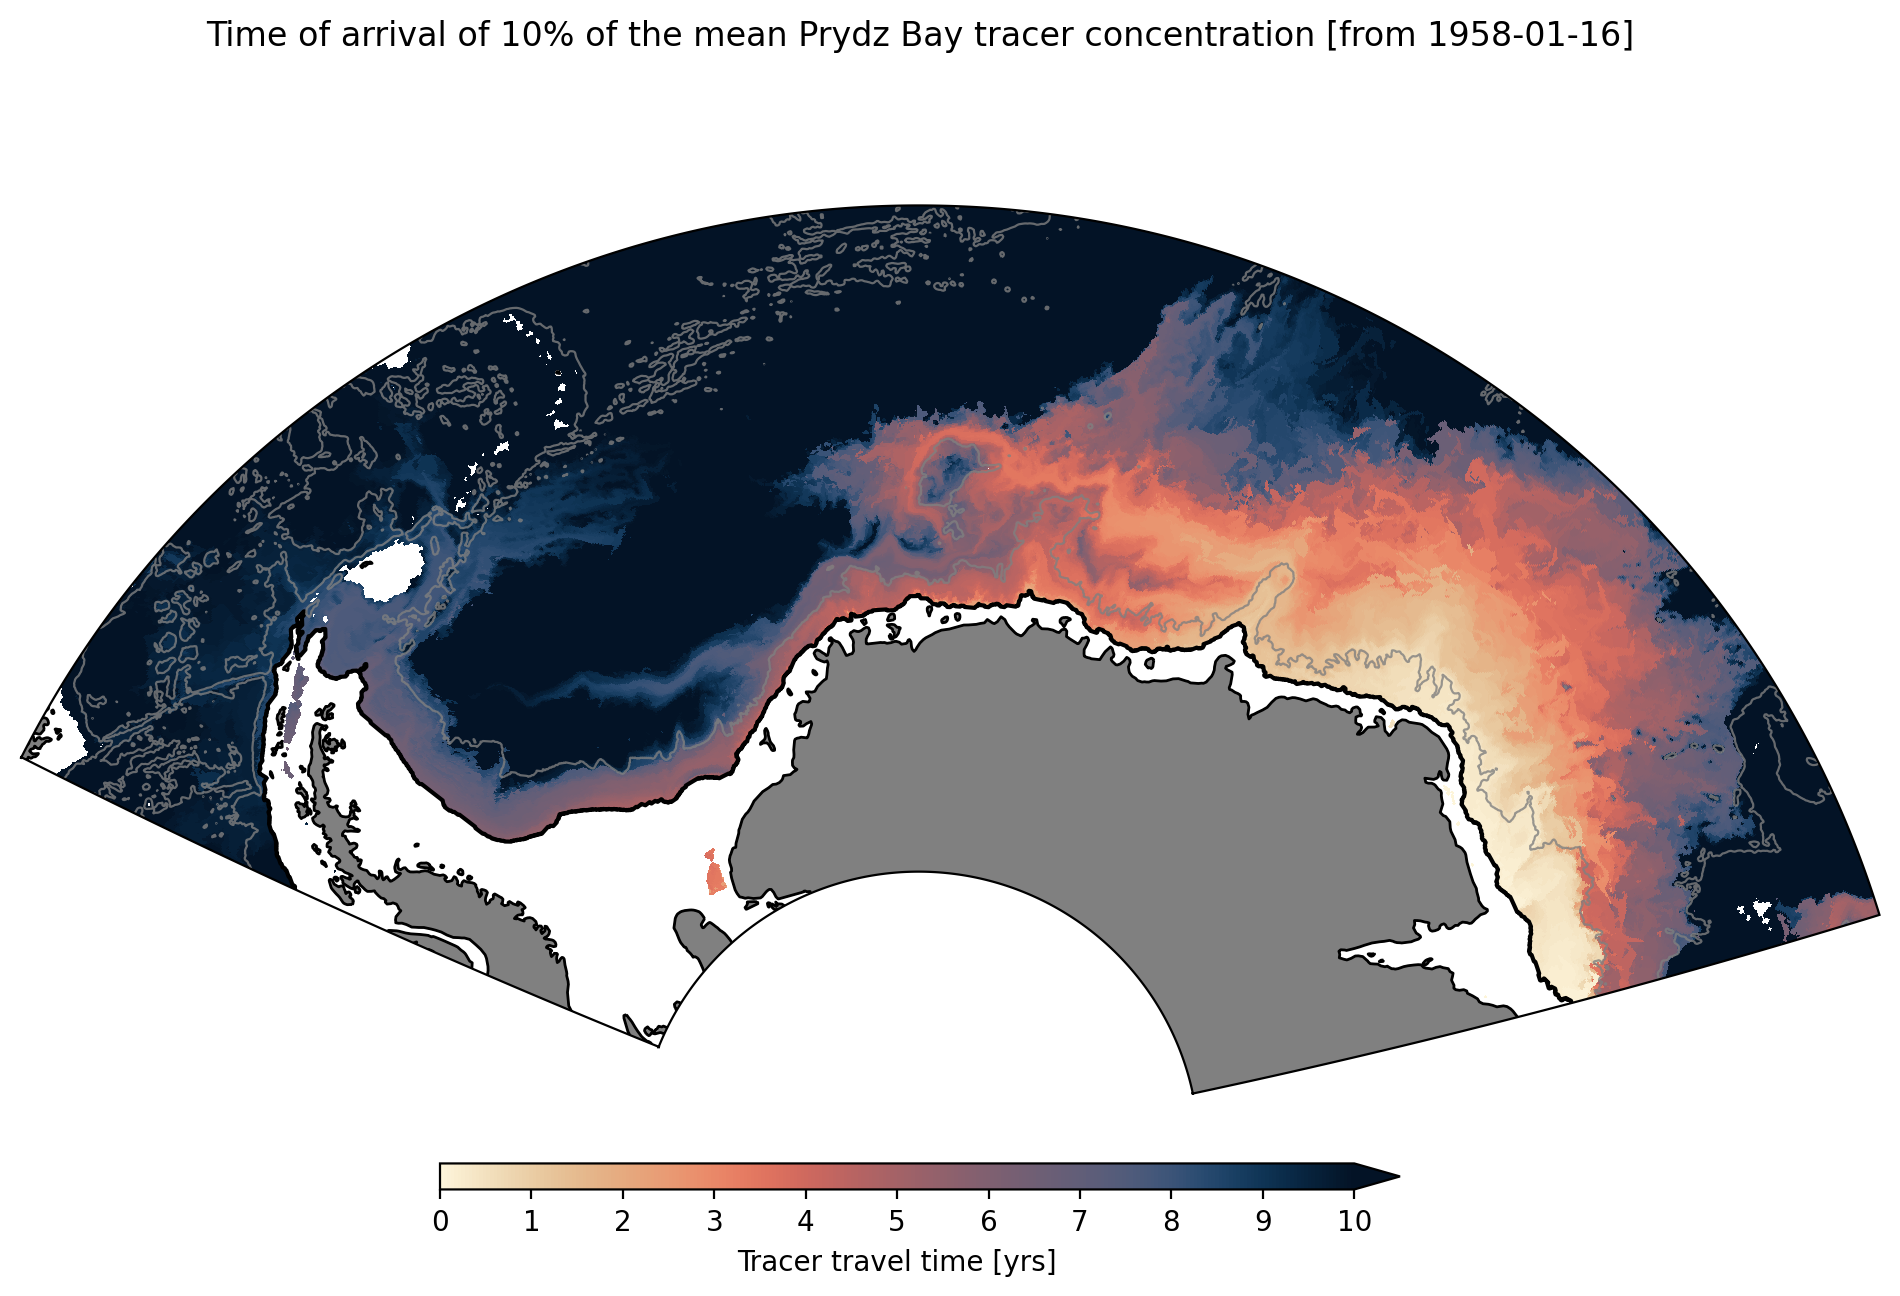

In [38]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, pbbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 10% of the mean Prydz Bay tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/pbbw_timing_map_10%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


## Threshold: 30% of the mean

In [41]:
condition = wsbw >= (wsbw_mean * 0.30)
wsbw_threshold_30 = wsbw.where(condition, drop=True)

condition = pbbw >= (pbbw_mean * 0.30)
pbbw_threshold_30 = pbbw.where(condition, drop=True)

In [42]:
wsbw_time_indices_30 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    wsbw_threshold_30,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
wsbw_timing_30 = wsbw.isel(time=wsbw_time_indices_30).time.dt.date



pbbw_time_indices_30 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    pbbw_threshold_30,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
pbbw_timing_30 = pbbw.isel(time=pbbw_time_indices_30).time.dt.date


In [45]:
start_time = datetime.date(1958, 1, 16)
wsbw_timedelta = ((wsbw_timing_30 - start_time).dt.days / 365) # in years
pbbw_timedelta = ((pbbw_timing_30 - start_time).dt.days / 365) # in years

wsbw_timedelta_mon = ((wsbw_timing_30 - start_time).dt.days/30) # in months
pbbw_timedelta_mon = ((pbbw_timing_30 - start_time).dt.days/30) # in months

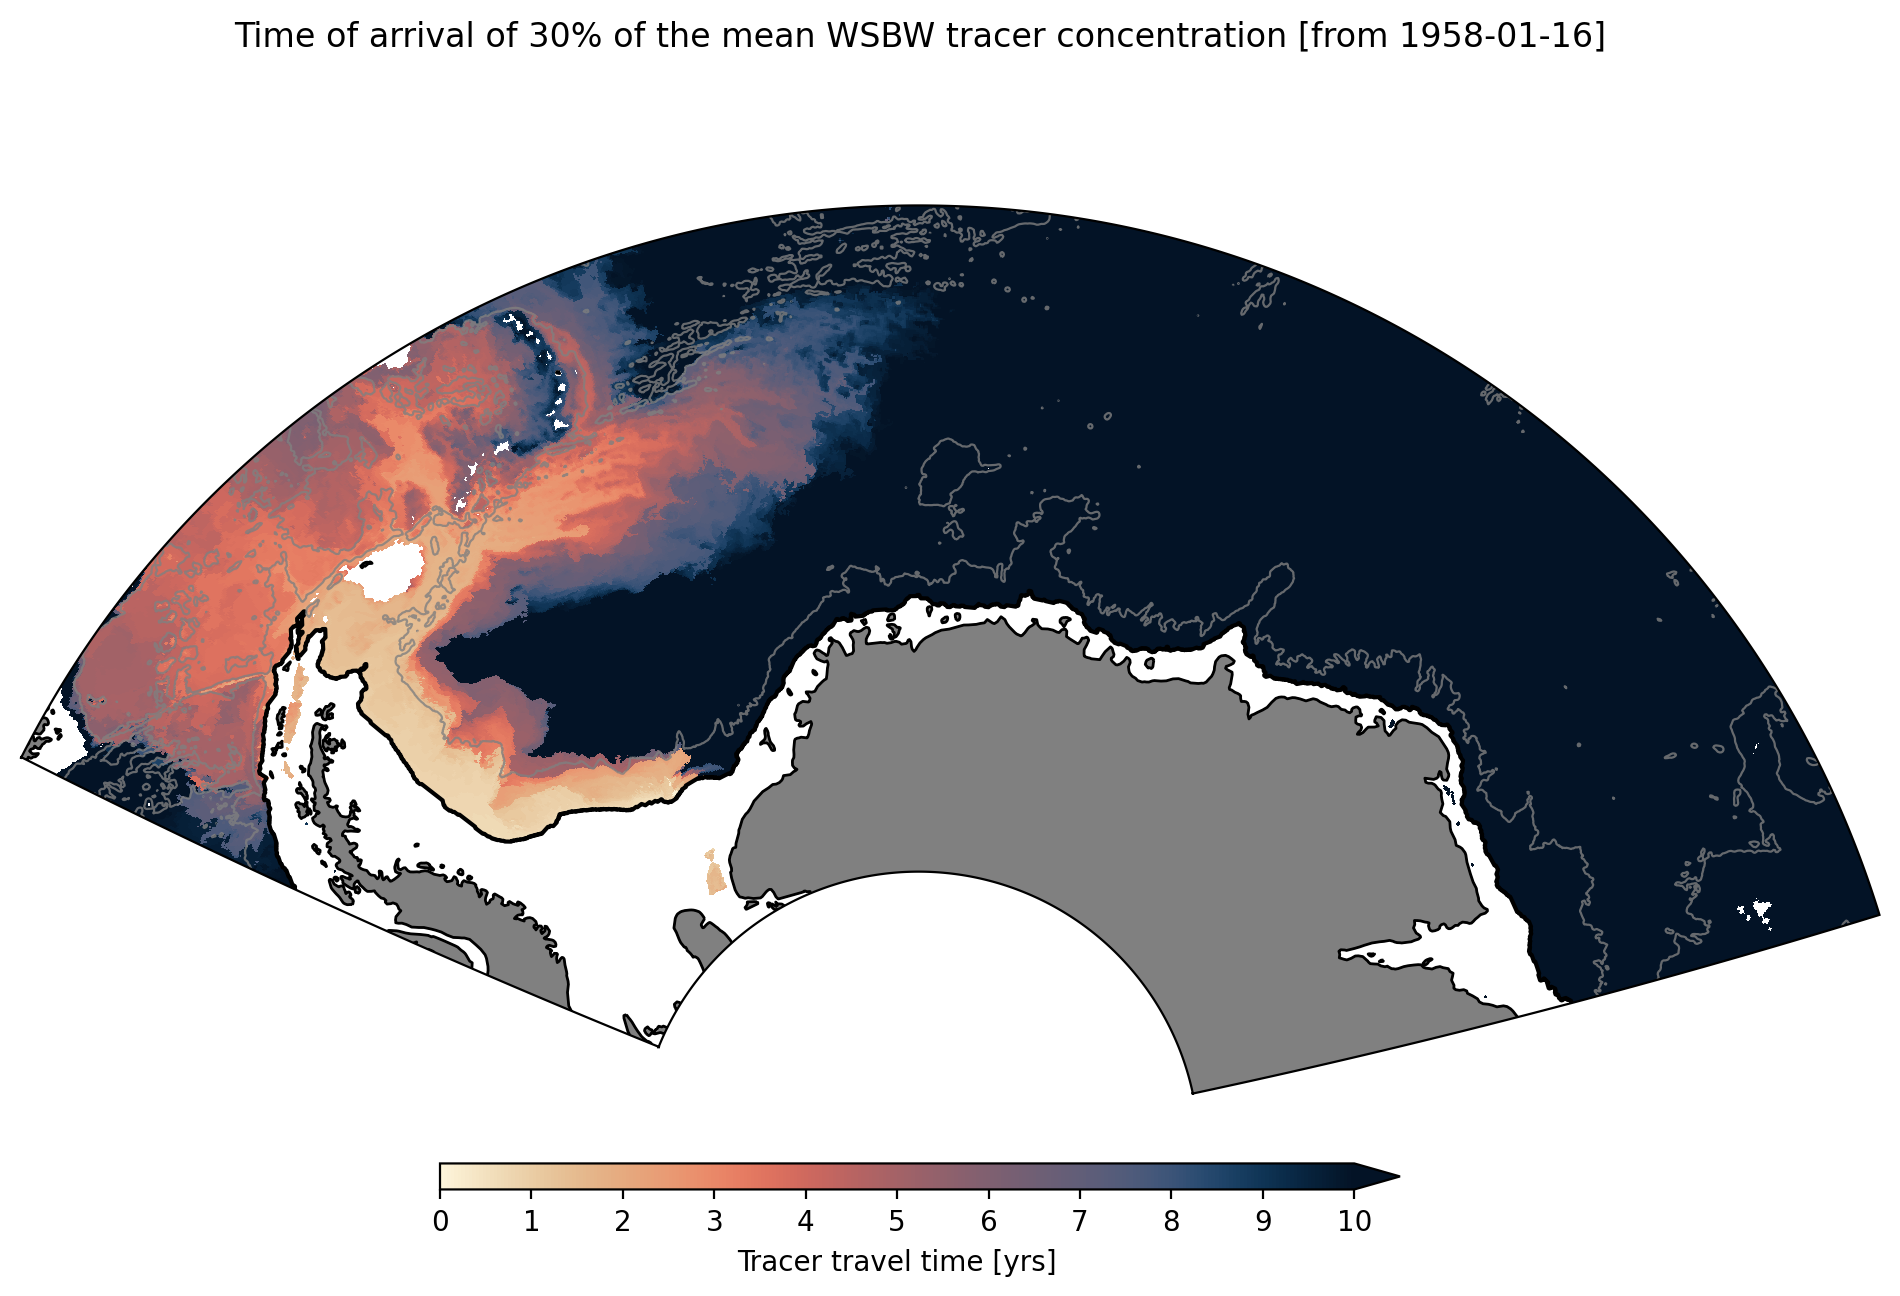

In [46]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 30% of the mean WSBW tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/wsbw_timing_map_30%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


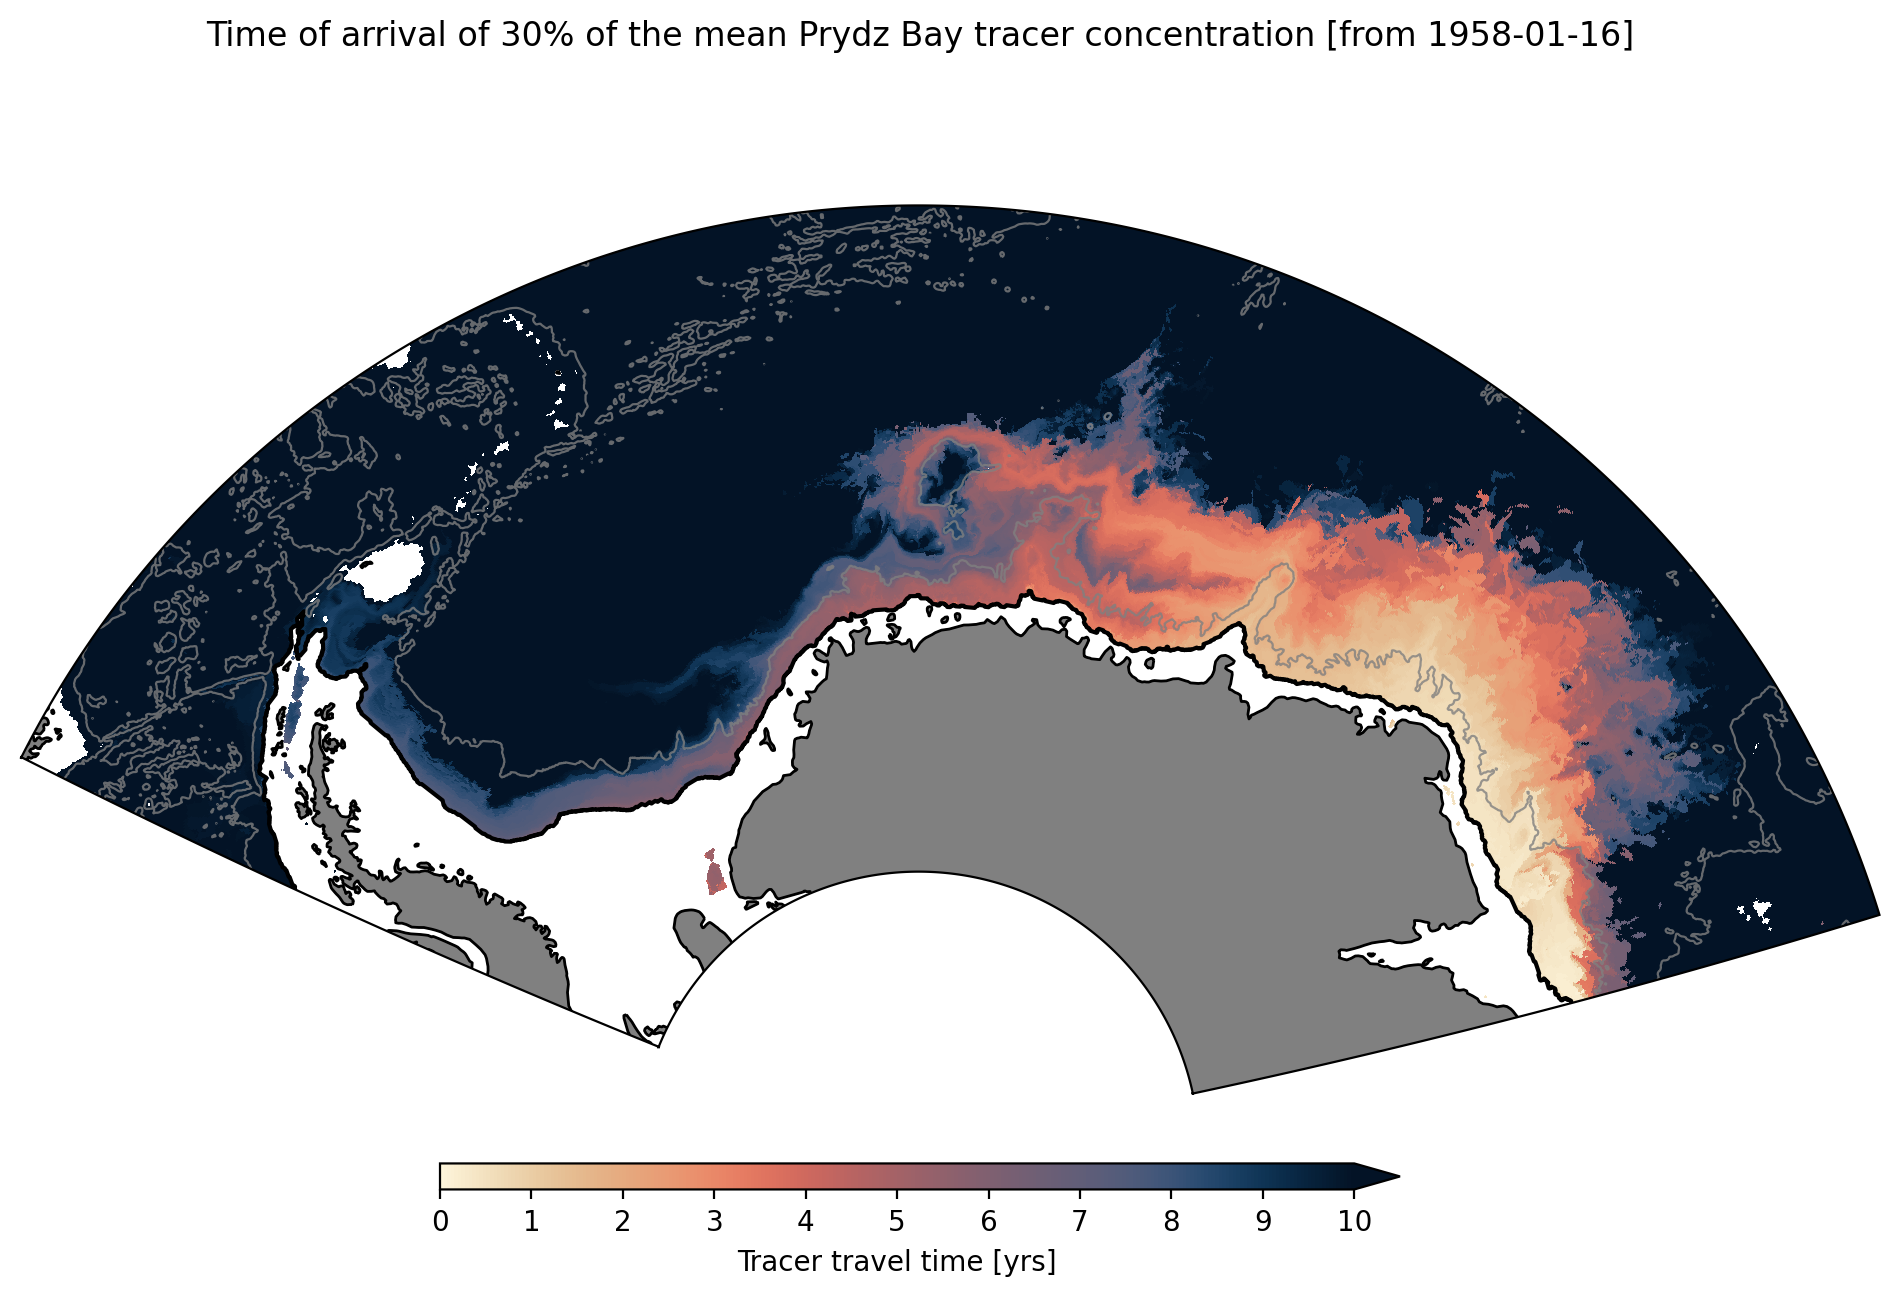

In [47]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, pbbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 30% of the mean Prydz Bay tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/pbbw_timing_map_30%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


### 50% threshold

In [54]:
condition = wsbw >= (wsbw_mean * 0.50)
wsbw_threshold_50 = wsbw.where(condition, drop=True)

condition = pbbw >= (pbbw_mean * 0.50)
pbbw_threshold_50 = pbbw.where(condition, drop=True)

In [55]:
wsbw_time_indices_50 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    wsbw_threshold_50,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
wsbw_timing_50 = wsbw.isel(time=wsbw_time_indices_50).time.dt.date



pbbw_time_indices_50 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    pbbw_threshold_50,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
pbbw_timing_50 = pbbw.isel(time=pbbw_time_indices_50).time.dt.date


In [56]:
start_time = datetime.date(1958, 1, 16)
wsbw_timedelta = ((wsbw_timing_50 - start_time).dt.days / 365) # in years
pbbw_timedelta = ((pbbw_timing_50 - start_time).dt.days / 365) # in years

wsbw_timedelta_mon = ((wsbw_timing_50 - start_time).dt.days/30) # in months
pbbw_timedelta_mon = ((pbbw_timing_50 - start_time).dt.days/30) # in months

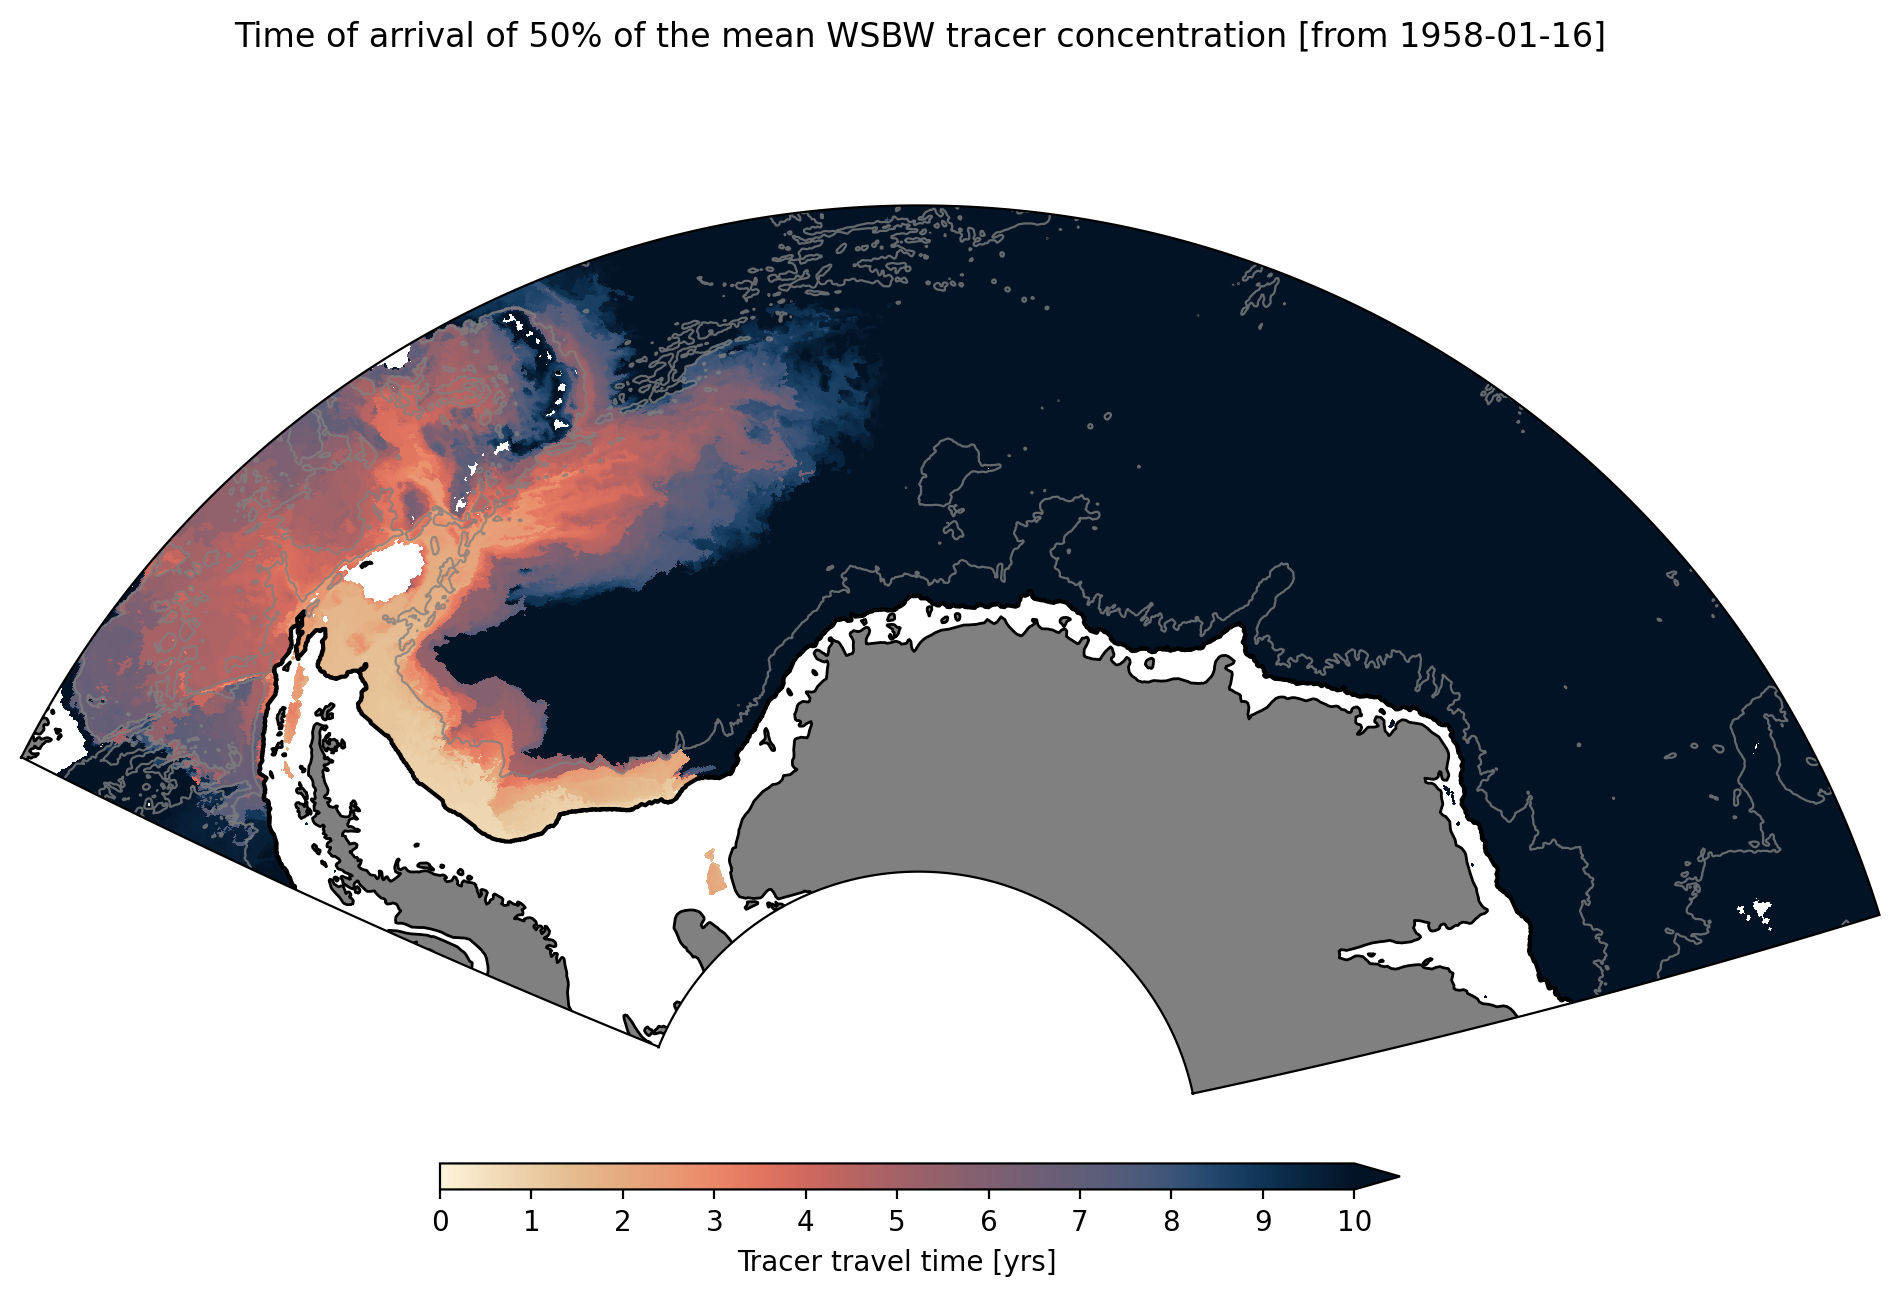

In [57]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 50% of the mean WSBW tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/wsbw_timing_map_50%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


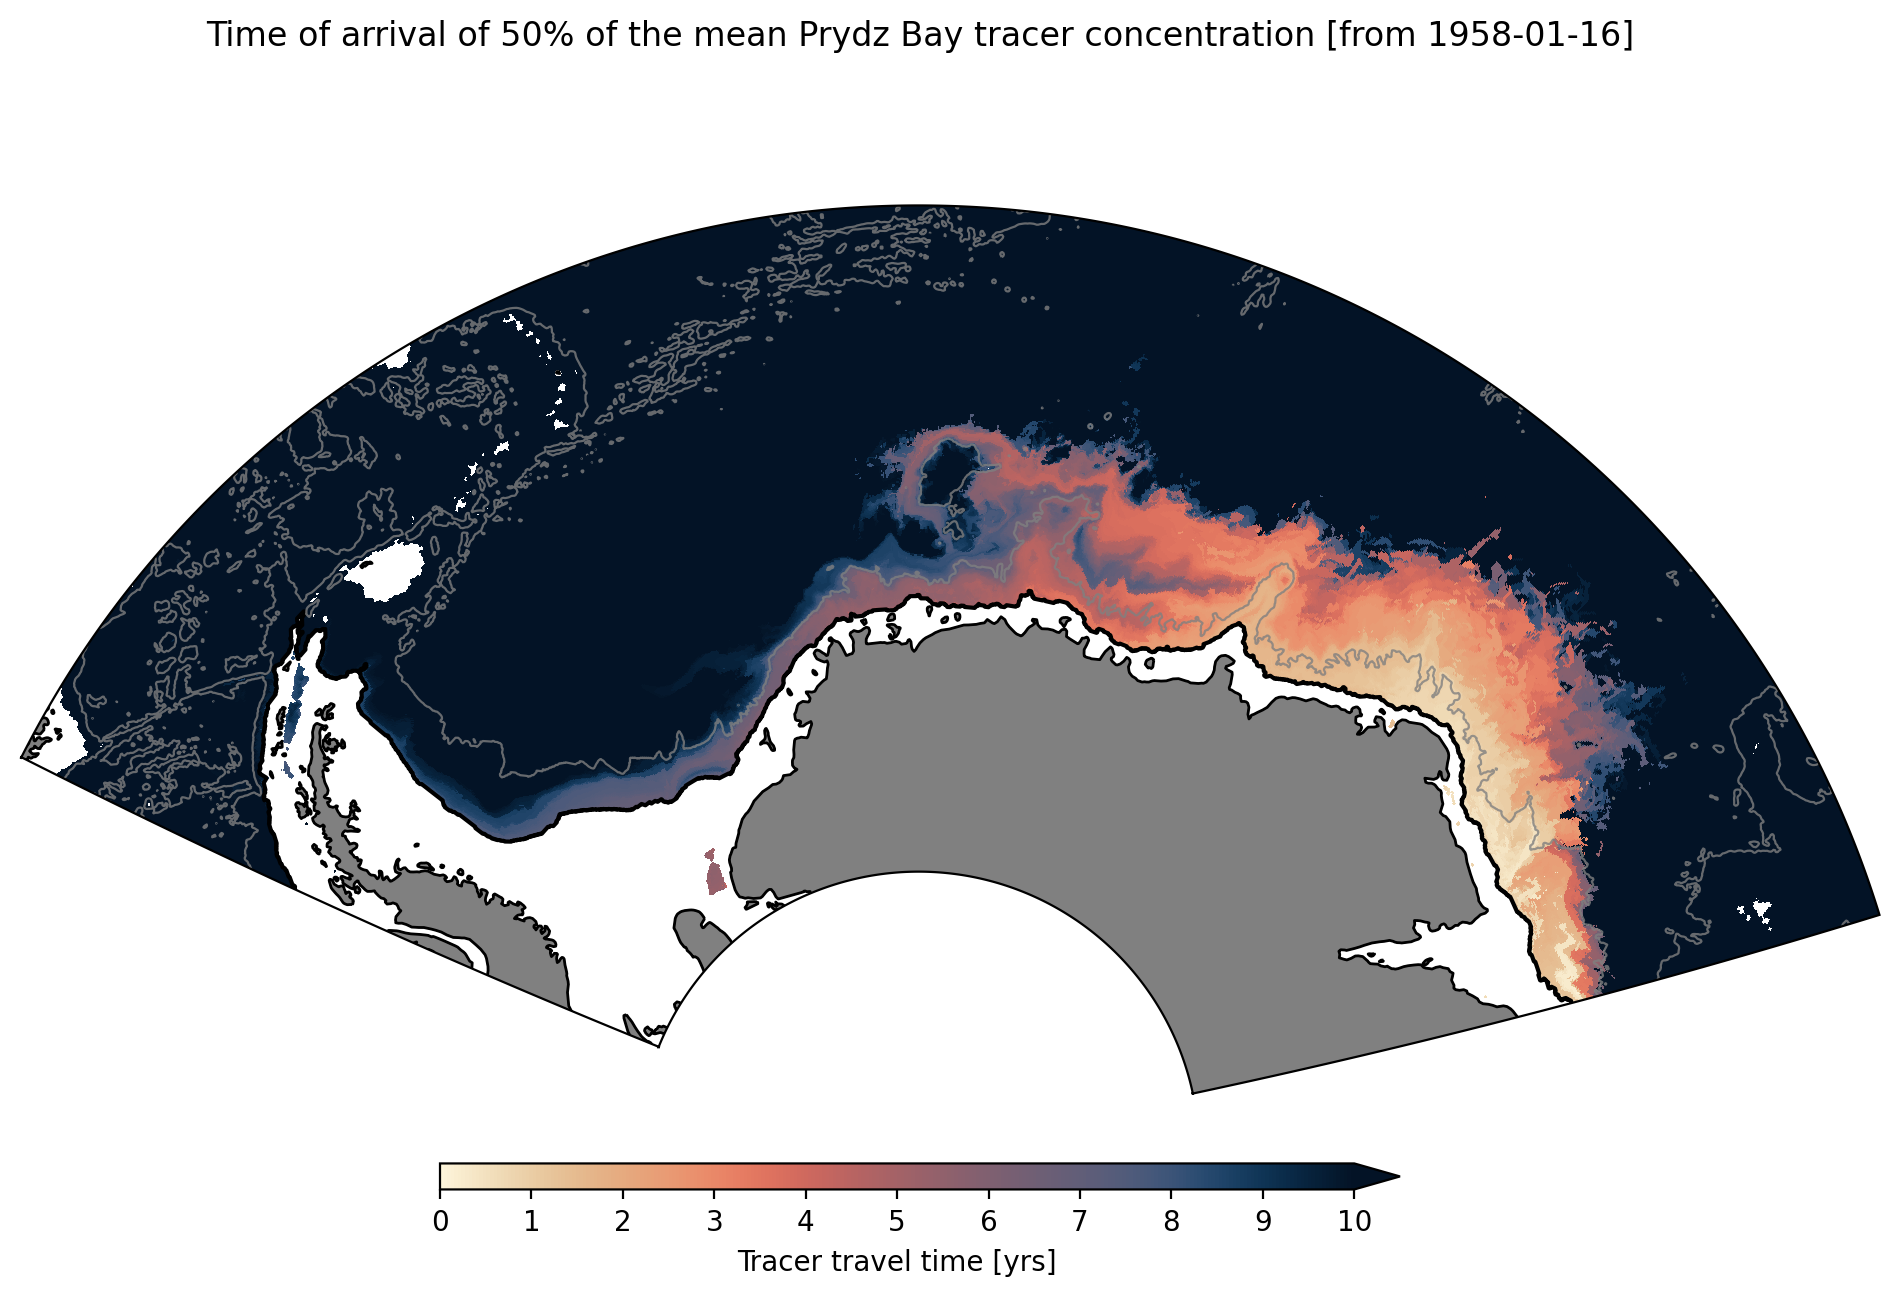

In [58]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, pbbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 50% of the mean Prydz Bay tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/pbbw_timing_map_50%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


## Threshold: 80%

In [49]:
condition = wsbw >= (wsbw_mean * 0.80)
wsbw_threshold_80 = wsbw.where(condition) 

condition = pbbw >= (pbbw_mean * 0.80)
pbbw_threshold_80 = pbbw.where(condition) 

In [50]:
wsbw_time_indices_80 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    wsbw_threshold_80,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
wsbw_timing_80 = wsbw.isel(time=wsbw_time_indices_80).time.dt.date



pbbw_time_indices_80 = xr.apply_ufunc(
    lambda arr: np.apply_along_axis(
        lambda x: np.where(~np.isnan(x))[0][0] if np.any(~np.isnan(x)) else -1, axis=0, arr=arr
    ),
    pbbw_threshold_80,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",  # Optional for large data
    output_dtypes=[int],
)
pbbw_timing_80 = pbbw.isel(time=pbbw_time_indices_80).time.dt.date


In [51]:
start_time = datetime.date(1958, 1, 16)
wsbw_timedelta = ((wsbw_timing_80 - start_time).dt.days / 365) # in years
pbbw_timedelta = ((pbbw_timing_80 - start_time).dt.days / 365) # in years

wsbw_timedelta_mon = ((wsbw_timing_80 - start_time).dt.days/30) # in months
pbbw_timedelta_mon = ((pbbw_timing_80 - start_time).dt.days/30) # in months

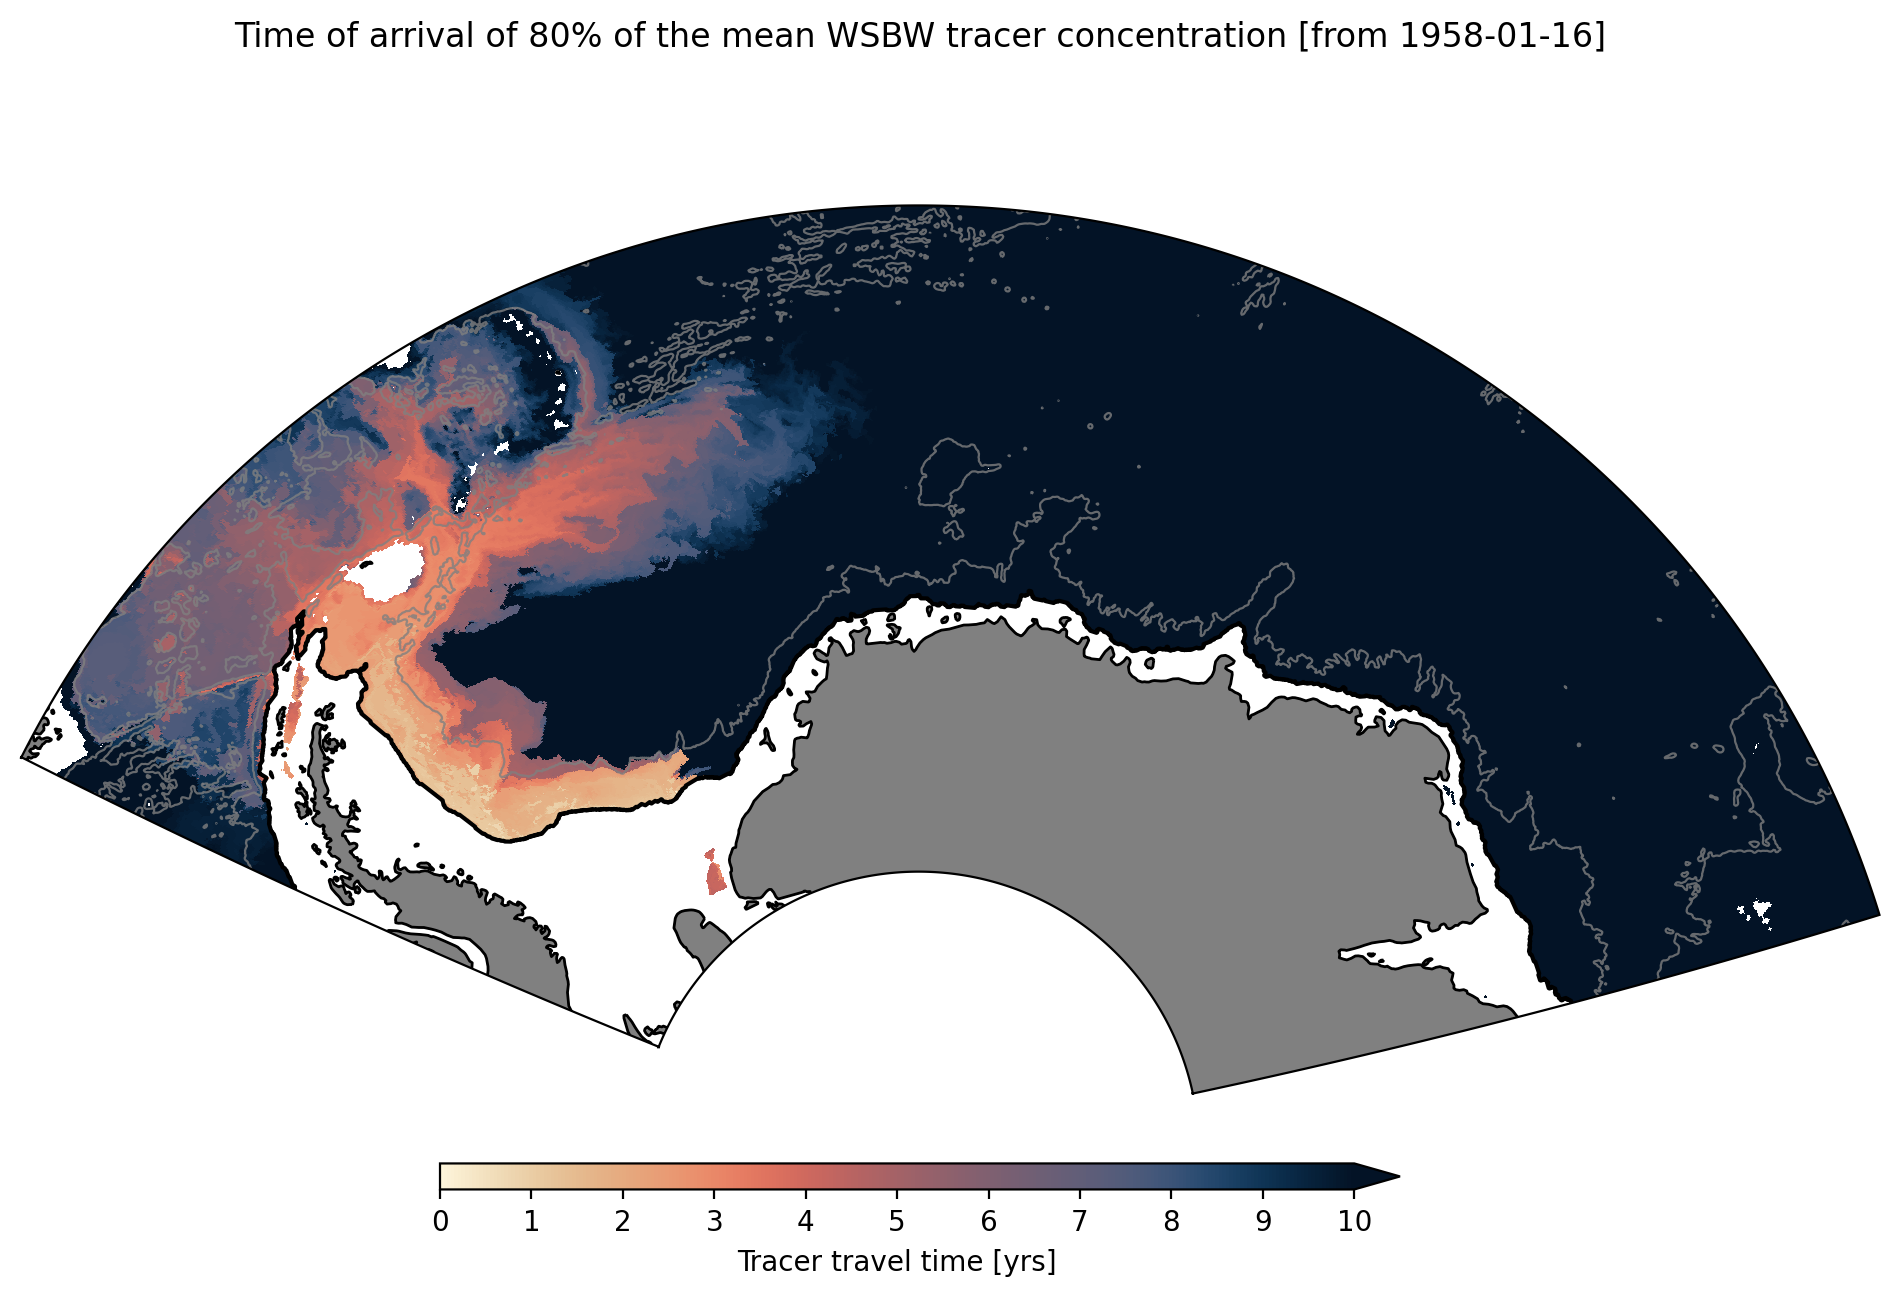

In [52]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 80% of the mean WSBW tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/wsbw_timing_map_80%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


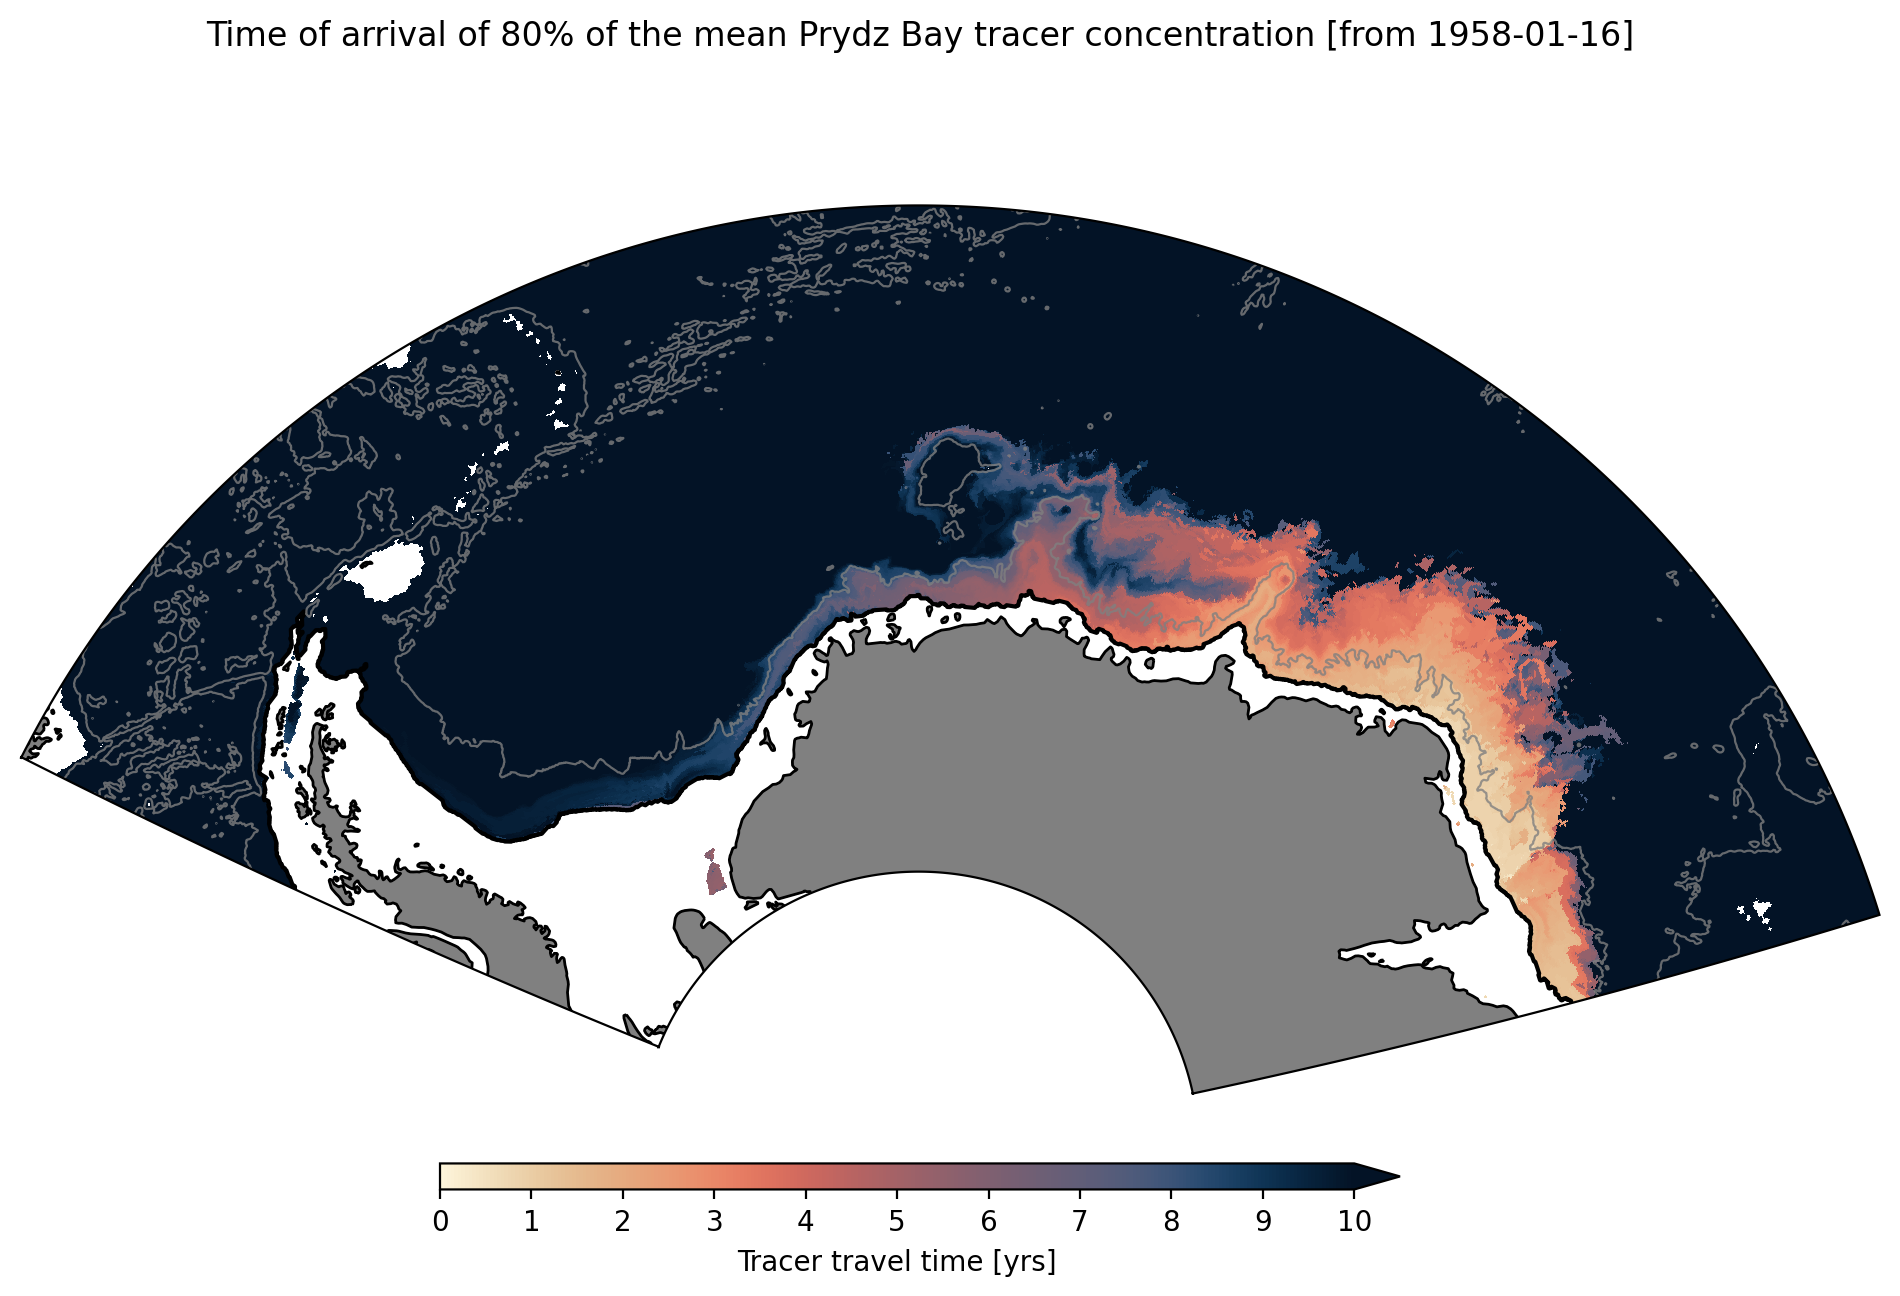

In [53]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=60, vmax=120)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, pbbw_timedelta_mon*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max', ticks=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
cbar.set_label(f'Tracer travel time [yrs]')

plt.suptitle('Time of arrival of 80% of the mean Prydz Bay tracer concentration [from 1958-01-16]')

plt.savefig(f'{figdir}/pbbw_timing_map_80%_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')
